In [4]:
from GraphicManager import GraphicManager
from GestuReNN_mts import GestuReNN_GRU #GestuReNN_mts_without_regression as GestuReNN
from DataLoader import DataLoader
import numpy as np
import time
import json

import tensorflow as tf
print('no. of gpus  ', tf.config.experimental.list_physical_devices("GPU"))

# test on test set
params = {
    "project_name": "shape recognition",
    "pad": True,
    "include_fingerup": False,
    "model_inputs": 'coord_and_tang',
    "test_size": 0.2,
    "dataset": 'Napkin',
    "load_mode": 'test',
    "augmentFactor": 0,
    "datasetFolder": './dataset/NapkinData/TestCSV',
    "fileType": 'csv',
    "labelJsonPath": './dataset/NapkinData/labelDict_11_classes.json',
    "batchSize": 128,
    "useSaliency": False,
    "isResample": False,
    "modelPath": './checkpoints/models/model_v2.2/files/model-best.h5'
}
    
    
# train on Napkin dataset.
# params = {
#     "project_name": "shape recognition",
#     "pad": True,
#     "include_fingerup": False,
#     "model_inputs": 'coord_and_tang',
#     "test_size": 0.2,
#     "dataset": 'Napkin',
#     "load_mode": 'train',
#     "augmentFactor": 6,
#     "datasetFolder": './dataset/NapkinData/NewTrainSet/csv',
#     "fileType": 'csv',
#     "labelJsonPath": './dataset/NapkinData/labelDict_11_classes.json',
#     "batchSize": 128,
#     "useSaliency": False,
#     "isResample": False,
#     "modelPath": './checkpoints/models/model_v2.2/files/model-best.h5'
# }


no. of gpus   [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# !pip install wandb
import wandb
from wandb.keras import WandbCallback
run = wandb.init(project=params["project_name"], config=params)

In [5]:
# Data loading
dl = DataLoader(dataset=params["dataset"], load_mode=params["load_mode"], labelJsonPath=params["labelJsonPath"], datasetFolder=params["datasetFolder"],
                fileType=params["fileType"], include_fingerup=params["include_fingerup"], model_inputs=params["model_inputs"],
                augmentFactor=params["augmentFactor"],isResample=params["isResample"], useSaliency=params["useSaliency"])

print(dl.validation_set[0].shape)
print(dl.train_set[0].shape)
for k, v in dl.labels_dict.items():
    print('{} - {}'.format(v, k))

Starting the DataLoader construction ...
stroke_dataset - Napkin
.. Done with attribute settings. Loading the data ...


/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/DataLoader.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] -= df['x'].iloc[0]
/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/DataLoader.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] -= df['y'].iloc[0]


42.55%- Loading on /content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/dataset/NapkinData/TestCSV
85.11%- Loading on /content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/dataset/NapkinData/TestCSV
Loading on /content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/dataset/NapkinData/TestCSV completed.
{'arrow_head': 0, 'triangle': 1, 'rectangle': 2, 'bracket': 3, 'small_cross': 4, 'arrow': 5, 'ellipse': 6, 'dot': 7, 'circle': 8, 'curly_braces': 9, 'garbage': 10}
.. Done with data loading. Setting up classifier attributes ...
.. Done with classifier attributes. Setting up regressor attributes ...
Done with DataLoader construction!
(234, 64, 4)
(234, 64, 4)
0 - arrow_head
1 - triangle
2 - rectangle
3 - bracket
4 - small_cross
5 - arrow
6 - ellipse
7 - dot
8 - circle
9 - curly_braces
10 - garbage


In [6]:
# with open(p.labelJsonPath, 'w') as fp:
#         json.dump(dl.labels_dict, fp)

In [ ]:
#print classwise training samples
temp = dl.train_set[1]
print(temp.shape)
countDict = {}
for i in range(temp.shape[0]):
  try:
    countDict[temp[i]] +=1
  except:
    countDict[temp[i]] =1
x = [i for i in range(len(dl.labels_dict))]
y = [countDict[i] for i in x]
for k in x:
  print("{}: {}".format(k, countDict[k]))


In [ ]:
# model initialization.
model = GestuReNN_GRU(plot=False, labelJsonPath=params["labelJsonPath"], model_inputs=params["model_inputs"],
                      batch_size=params["batchSize"], model_path=params["modelPath"], include_fingerup=params["include_fingerup"], useSaliency=params["useSaliency"])
graphic_manager = GraphicManager(dataset=params["dataset"], n_bins=10)

In [ ]:
WandbCallback().save_weights_only=True
WandbCallback().filepath = params["modelPath"]

In [ ]:
#convert to tensorflow JS model.
model.load_model_with_state()
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model.model_with_state, "/Users/murtuza/Desktop")

In [ ]:
if params["load_mode"] == 'train':
    with open(params["labelJsonPath"], 'w') as fp:
        json.dump(dl.labels_dict, fp)
    model.fit_model(dl.train_set_classifier,
                        dl.validation_set_classifier,
                        dl.train_set_regressor,
                        dl.validation_set_regressor,
                        dl.y_train_binary,
                        dl.y_test_binary,
                        wandbCallBacks=[WandbCallback()])
    arrowMetrics, clfMetrics = graphic_manager.generate_progressive_accuracy(model, dl.test_set_classifier, dl.y_test_binary, plot_clf=True, plot_reg=False,
                                                  best_of=1, indexToLabel=dl.get_index_to_label())
    wandb.log({"arrow Classifier": arrowMetrics, "classfier": clfMetrics})
else:
    print("loading model ...")
    model.load_model()
    print('Model Loaded!!')
    graphic_manager.generate_progressive_accuracy(model, dl.test_set_classifier, plot_clf=True, plot_reg=False,
                                                  best_of=1, indexToLabel=dl.get_index_to_label())

wandb.finish()

loading model ...
/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/checkpoints/models/gru_input_dim3/mdcp_robust.ckpt
Model Loaded!!


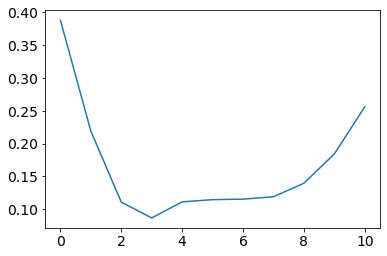

arrow_head (23.0) - | arrow_head: 19.0| triangle: 3.0| arrow: 1.0  | 82.6086956521739%
triangle (23.0) - | triangle: 19.0| rectangle: 3.0| garbage: 1.0  | 82.6086956521739%
rectangle (22.0) - | triangle: 8.0| rectangle: 12.0| small_cross: 1.0| garbage: 1.0  | 54.54545454545455%
bracket (23.0) - | arrow_head: 1.0| bracket: 21.0| curly_braces: 1.0  | 91.30434782608695%
small_cross (21.0) - | arrow_head: 15.0| triangle: 1.0| small_cross: 3.0| dot: 2.0  | 14.285714285714286%
arrow (20.0) - | triangle: 2.0| rectangle: 2.0| arrow: 15.0| circle: 1.0  | 75.0%
ellipse (23.0) - | triangle: 1.0| ellipse: 13.0| circle: 2.0| curly_braces: 4.0| garbage: 3.0  | 56.52173913043478%
dot (21.0) - | arrow_head: 7.0| arrow: 2.0| dot: 11.0| circle: 1.0  | 52.38095238095238%
circle (19.0) - | circle: 18.0| garbage: 1.0  | 94.73684210526316%
curly_braces (22.0) - | triangle: 2.0| rectangle: 2.0| curly_braces: 14.0| garbage: 4.0  | 63.63636363636363%
garbage (17.0) - | rectangle: 2.0| ellipse: 1.0| garbage: 14

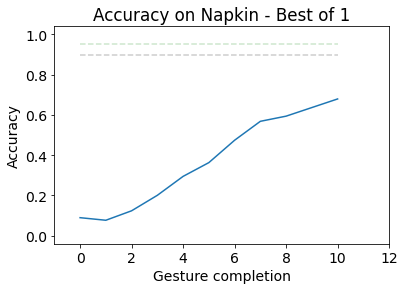

[0.08974359 0.07692308 0.12393162 0.2008547  0.29487179 0.36324786
 0.47435897 0.56837607 0.59401709 0.63675214 0.67948718]


In [ ]:
# Gru_input_dim_3
if p.load_mode == 'train':
    with open(p.labelJsonPath, 'w') as fp:
        json.dump(dl.labels_dict, fp)
    model_mts.fit_model(dl.train_set_classifier,
                        dl.validation_set_classifier,
                        dl.train_set_regressor,
                        dl.validation_set_regressor)
else:
    print("loading model ...")
    model_mts.load_model()
    print('Model Loaded!!')
    graphic_manager.generate_progressive_accuracy(model_mts, dl.test_set_classifier, plot_clf=True, plot_reg=False,
                                                  best_of=1, indexToLabel=dl.get_index_to_label())

loading model ...
/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/checkpoints/models/Napkin_latest/mdcp_robust.ckpt
Model Loaded!!


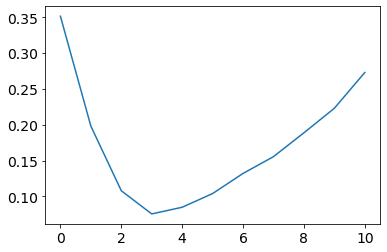

arrow_head (23.0) - | arrow_head: 21.0| triangle: 2.0  | 91.30434782608695%
triangle (23.0) - | triangle: 17.0| rectangle: 4.0| small_cross: 1.0| garbage: 1.0  | 73.91304347826087%
rectangle (22.0) - | triangle: 2.0| rectangle: 17.0| bracket: 1.0| ellipse: 2.0  | 77.27272727272727%
bracket (23.0) - | bracket: 18.0| curly_braces: 5.0  | 78.26086956521739%
small_cross (21.0) - | arrow_head: 8.0| small_cross: 13.0  | 61.904761904761905%
arrow (20.0) - | triangle: 1.0| rectangle: 2.0| arrow: 9.0| ellipse: 2.0| circle: 1.0| curly_braces: 3.0| garbage: 2.0  | 45.0%
ellipse (23.0) - | triangle: 6.0| rectangle: 3.0| ellipse: 13.0| circle: 1.0  | 56.52173913043478%
dot (21.0) - | dot: 20.0| circle: 1.0  | 95.23809523809524%
circle (19.0) - | triangle: 1.0| circle: 18.0  | 94.73684210526316%
curly_braces (22.0) - | curly_braces: 21.0| garbage: 1.0  | 95.45454545454545%
garbage (17.0) - | ellipse: 3.0| garbage: 14.0  | 82.3529411764706%


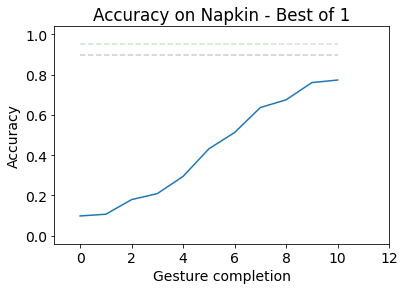

In [ ]:
if p.load_mode == 'train':
    with open(p.labelJsonPath, 'w') as fp:
        json.dump(dl.labels_dict, fp)
    model_mts.fit_model(dl.train_set_classifier,
                        dl.validation_set_classifier,
                        dl.train_set_regressor,
                        dl.validation_set_regressor)
else:
    print("loading model ...")
    model_mts.load_model()
    print('Model Loaded!!')
    graphic_manager.generate_progressive_accuracy(model_mts, dl.test_set_classifier, plot_clf=True, plot_reg=False,
                                                  best_of=1, indexToLabel=dl.get_index_to_label())

loading model ...
/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/checkpoints/models/Napkin_latest/mdcp_robust.ckpt
Model Loaded!!


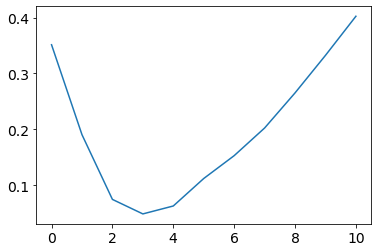

arrow_head (4.0) - | arrow_head: 4.0  | 100.0%
triangle (0.0) -   | nan%
rectangle (18.0) - | triangle: 1.0| rectangle: 12.0| arrow: 1.0| ellipse: 1.0| curly_braces: 3.0  | 66.66666666666667%
bracket (0.0) -   | nan%
small_cross (0.0) -   | nan%
arrow (11.0) - | arrow: 10.0| garbage: 1.0  | 90.9090909090909%
ellipse (0.0) -   | nan%
dot (0.0) -   | nan%
circle (13.0) - | ellipse: 3.0| circle: 10.0  | 76.92307692307692%
curly_braces (0.0) -   | nan%
garbage (0.0) -   | nan%


/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/GraphicManager.py:309: RuntimeWarning: invalid value encountered in double_scalars
  strng += "  | {}%".format((prediction_statistics[i, i] * 100) / np.sum(prediction_statistics[i, :]))


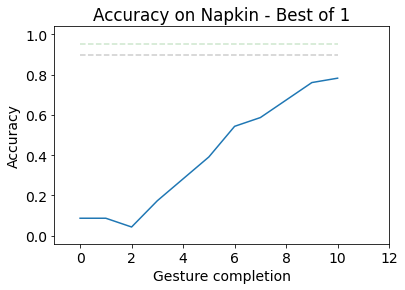

In [ ]:
if p.load_mode == 'train':
    with open(p.labelJsonPath, 'w') as fp:
        json.dump(dl.labels_dict, fp)
    model_mts.fit_model(dl.train_set_classifier,
                        dl.validation_set_classifier,
                        dl.train_set_regressor,
                        dl.validation_set_regressor)
else:
    print("loading model ...")
    model_mts.load_model()
    print('Model Loaded!!')
    graphic_manager.generate_progressive_accuracy(model_mts, dl.test_set_classifier, plot_clf=True, plot_reg=False,
                                                  best_of=1, indexToLabel=dl.get_index_to_label())

loading model ...
/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/checkpoints/models/Napkin_trial/mdcp_robust.ckpt
Model Loaded!!
--------Sample - 0----------
classification gt, [pred] 2 [2]
--------Sample - 1----------
classification gt, [pred] 2 [2]
--------Sample - 2----------
classification gt, [pred] 2 [2]
--------Sample - 3----------
classification gt, [pred] 2 [2]
--------Sample - 4----------
classification gt, [pred] 2 [2]
--------Sample - 5----------
classification gt, [pred] 2 [5]
--------Sample - 6----------
classification gt, [pred] 2 [2]
--------Sample - 7----------
classification gt, [pred] 2 [2]
--------Sample - 8----------
classification gt, [pred] 2 [2]
--------Sample - 9----------
classification gt, [pred] 2 [2]
--------Sample - 10----------
classification gt, [pred] 2 [2]
--------Sample - 11----------
classification gt, [pred] 2 [2]
--------Sample - 12----------
classification gt, [pred] 2 [5]
--------Sample - 13----------
classification gt, [pred] 2 [

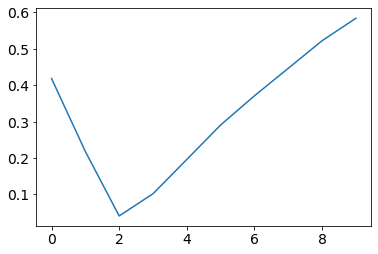

arrow_head (4.0) - | arrow_head: 1.0| triangle: 1.0| bracket: 1.0| circle: 1.0  | 25.0%
triangle (0.0) -   | nan%
rectangle (18.0) - | rectangle: 16.0| arrow: 2.0  | 88.88888888888889%
bracket (0.0) -   | nan%
small_cross (0.0) -   | nan%
arrow (11.0) - | rectangle: 2.0| arrow: 9.0  | 81.81818181818181%
ellipse (0.0) -   | nan%
dot (0.0) -   | nan%
circle (13.0) - | circle: 13.0  | 100.0%
curly_braces (0.0) -   | nan%


/content/drive/MyDrive/second_layer_ai_model/SketchAI/SketchAI/GraphicManager.py:313: RuntimeWarning: invalid value encountered in double_scalars
  strng += "  | {}%".format((prediction_statistics[i, i] * 100) / np.sum(prediction_statistics[i, :]))


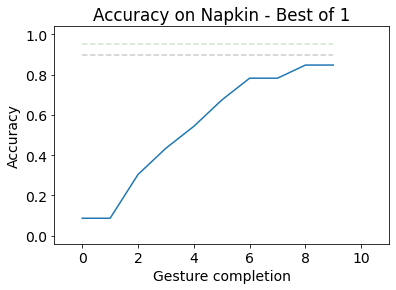

In [ ]:
#napkin trial
if p.load_mode == 'train':
    with open(p.labelJsonPath, 'w') as fp:
        json.dump(dl.labels_dict, fp)
    model_mts.fit_model(dl.train_set_classifier,
                        dl.validation_set_classifier,
                        dl.train_set_regressor,
                        dl.validation_set_regressor)
else:
    print("loading model ...")
    model_mts.load_model()
    print('Model Loaded!!')
    graphic_manager.generate_progressive_accuracy(model_mts, dl.test_set_classifier, plot_clf=True, plot_reg=False,
                                                  best_of=1, indexToLabel=dl.get_index_to_label())


In [ ]:
print(tf.__version__)